# Графики, дашборды и мониторинги

Визуализация данных. Redash

1) Ваш менее опытный коллега не уверен, что его таблица retail действительно создалась и добавилась в базу данных. Напишите запрос, который создаст таблицу, если она еще не существует (IF NOT EXISTS), со следующими параметрами:

Название: retail

База: test

Столбцы:
- InvoiceNo – идентификатор заказа, строковое значение
- StockCode – идентификатор товара, строковое значение
- Description – описание товара, строковое значение
- Quantity – количество единиц товара, добавленных в корзину (особенность данных – значения могут быть отрицательными, 32 бита)
- InvoiceDate – дата и время создания заказа (транзакции), часовой пояс – 'Europe/London'
- UnitPrice – цена за единицу товара (особенность данных – значения могут быть отрицательными, точность – три знака после точки, 64 бита)
- CustomerID – идентификатор пользователя, целое положительное число, 32 бита.
- Country – страна, строковое значение. 

Движок: MergeTree

Сортировка: InvoiceDate, CustomerID

   
    CREATE TABLE IF NOT EXISTS test.retail (
        InvoiceNo String,
        StockCode String,
        Description String,
        Quantity Int32,
        InvoiceDate DateTime('Europe/London'),
        UnitPrice Decimal64(3),
        CustomerID UInt32,
        Country String
        )
    ENGINE = MergeTree 
    ORDER BY (InvoiceDate, CustomerID)


В следующих шагах используется default.retail – данные о транзакциях британского интернет-магазина в период с 1 декабря 2010 по 9 декабря 2011, где:
- InvoiceNo – номер транзакции
- StockCode – код товара
- Description – описание товара
- Quantity – количество единиц товара, добавленных в заказ
- InvoiceDate – дата транзакции 
- UnitPrice – цена за единицу товара
- CustomerID – id клиента
- Country – страна, где проживает клиент

Для выполнения заданий и построения графиков понадобится Redash

2) Для начала посмотрите, в каких странах имеется наибольшее число уникальных пользователей. Постройте барчарт, где:
- по оси x – страна
- по оси y – число пользователей

В качестве ответа укажите число уникальных пользователей из Великобритании. 


    SELECT
        Country,
        uniqExact(CustomerID) AS uniq_CustomerID
    FROM default.retail
    GROUP BY Country
    ORDER BY uniq_CustomerID DESC



3) Следующая задача – посмотреть на динамику изменения числа активных пользователей в месяц в Великобритании, Австралии и Нидерландах. Полученная вами результирующая таблица должна иметь вид: страна - число уникальных пользователей за определённый месяц.

MAU (monthly active users) – число уникальных пользователей за месяц. Активные пользователи – те, кто сделал хотя бы один заказ за выбранный промежуток времени (месяц).
В качестве ответа укажите наименьшее число пользователей за февраль 2011. 


    SELECT 
        Country,
        toStartOfMonth(InvoiceDate) AS Date,
        uniqExact(CustomerID) AS uniq_customerid

    FROM  
        default.retail

    WHERE (Country = 'United Kingdom' OR Country = 'Australia' OR Country = 'Netherlands') AND Date = '2011-02-01'

    GROUP BY 
        Country, Date 

    ORDER BY 
        uniq_customerid DESC


4) Теперь проанализируем сами заказы. Посчитайте среднюю сумму заказа (AOV – average order value) в каждой из стран.
Визуализируйте результат. Из представленных вариантов ответа выберите страны, входящие в топ-3 по величине средней суммы заказа.



    SELECT 
        Country, 
        avg(sum_TotalPrice) AS aov_price

    FROM 
        (
        SELECT 
            Country,
            InvoiceNo, 
            sum(Quantity * UnitPrice) AS sum_TotalPrice

        FROM  
            default.retail

        WHERE Quantity > -1

        GROUP BY Country, InvoiceNo
        )

    GROUP BY Country 
    ORDER BY 
        aov_price DESC 


5) Как изменялась средняя сумма заказа в разных странах по месяцам?
Предположим, нас интересует динамика в следующих странах: United Kingdom, Germany, France, Spain, Netherlands, Belgium, Switzerland, Portugal, Australia, USA. 

    SELECT 
        Country, 
        Date,
        avg(sum_TotalPrice) AS aov_price

    FROM 
        (
        SELECT 
            Country,
            InvoiceNo, 
            toStartOfMonth(InvoiceDate) AS Date,
            sum(Quantity * UnitPrice) AS sum_TotalPrice

        FROM  
            default.retail

        WHERE 
            Quantity > -1
        AND Country IN ('United Kingdom', 'Germany', 'France', 'Spain', 'Netherlands', 'Belgium', 'Switzerland', 'Portugal', 'Australia', 'USA')

        GROUP BY Country, InvoiceNo, Date
        )

    GROUP BY Country, Date
    ORDER BY 
        aov_price DESC



6) Сколько товаров пользователи обычно добавляют в корзину? Посчитайте среднее количество товаров, добавленных в корзину, с разбивкой по странам. В качестве ответа укажите среднее число товаров в заказе среди пользователей в Канаде (Canada). 

    SELECT 
        Country, 
        avg(sum_quantity) AS avg_quantity

    FROM 
        (
        SELECT 
            Country,
            InvoiceNo,
            sum(Quantity) AS sum_quantity

        FROM  
            default.retail

        GROUP BY Country, InvoiceNo
        )

    WHERE Country = 'Canada'
    GROUP BY Country


7) Возможно, результат на предыдущем шаге показался вам странным, особенно если соотнести средний размер корзины с числом уникальных пользователей в некоторых странах. 
Посмотрим на Нидерланды (Netherlands) более подробно. Сгруппируйте данные по пользователям и посмотрите, кто купил наибольшее число товаров. В ответе укажите идентификатор данного пользователя. 

    SELECT 
        CustomerID,        
        sum(Quantity) AS sum_quantity

    FROM  
        default.retail

    WHERE Country = 'Netherlands'
    GROUP BY CustomerID 
    ORDER BY sum_quantity DESC


**8) Задание на построение дашборда**

Следующая задача: подготовить дашборд в Redash, состоящий из более чем четырех графиков

Дашборд для отдела продаж онлайн магазина: вывести основные показатели (KPI), которые позволили бы понимать текущее состояние бизнеса в целом и в разных странах, а также динамику наиболее важных метрик (например, выручку и разбивку по странам, количество уникальных пользователей, заказов, средний чек, топ товаров, и другие графики, которые будут полезны для понимания)

Данные: ClickHouse → default.retail

**Идея:**
Первичное исследование общей динамики продаж британского онлайн-магазина в течение 2010 года, а также в разрезе по странам. Определение стран с лучшими показателями по средней выручке, количеству заказов, количеству товаров, количеству уникальных пользователей, топу товаров. 

Это позволит понять текущее состояние бизнеса в целом и в разных странах, а также динамику важных для бизнеса метрик.
Графическое представление данных полезно для лучшего понимания ситуации.


**Примеры запросов:**

- число уникальных пользователей по странам 


    SELECT
        Country,
        uniqExact(CustomerID) AS uniq_CustomerID
    FROM default.retail
    GROUP BY Country
    ORDER BY uniq_CustomerID DESC


- число уникальных пользователей по датам 


    SELECT
        toStartOfMonth(InvoiceDate) AS Date,
        uniqExact(CustomerID) AS uniq_CustomerID
    FROM default.retail
    GROUP BY Date
    ORDER BY uniq_CustomerID DESC




- число уникальных пользователей по странам и датам (БЕЗ АНГЛИИ)


    SELECT
        Country,
        toStartOfMonth(InvoiceDate) AS Date,
        uniqExact(CustomerID) AS uniq_CustomerID
    FROM default.retail
    WHERE Country != 'United Kingdom'
    GROUP BY Country, Date
    ORDER BY uniq_CustomerID DESC


- число уникальных заказов по странам и датам (БЕЗ АНГЛИИ)


    SELECT
        Country,
        toStartOfMonth(InvoiceDate) AS Date,
        uniqExact(InvoiceNo) AS uniq_InvoiceNo
    FROM default.retail
    WHERE Country != “United Kingdom’
    GROUP BY Country, Date
    ORDER BY uniq_InvoiceNo DESC


- динамика средней выручки по странам (БЕЗ АНГЛИИ)


    SELECT 
        Country, 
        Date,
        avg(sum_TotalPrice) AS aov

    FROM 
        (
        SELECT 
            Country,
            toStartOfMonth(InvoiceDate) AS Date, 
            sum(Quantity * UnitPrice) AS sum_TotalPrice

        FROM  
            default.retail

        WHERE 
            Quantity > -1
        AND Country != 'United Kingdom'

        GROUP BY Country, Date
        )

    GROUP BY Country, Date
    ORDER BY aov DESC


- MAU – число уникальных АКТИВНЫХ пользователей по стране дате


    SELECT 
        Country,
        toStartOfMonth(InvoiceDate) AS Date,
        count(InvoiceNo) AS count_order,
        uniqExact(CustomerID) AS mau
    FROM  
        default.retail
    GROUP BY 
        Country, Date 
    HAVING 
        count_order > 0
    ORDER BY 
        mau DESC


- avg quantity по странам


    SELECT 
        Country, 
        avg(sum_quantity) AS avg_quantity

    FROM 
        (
        SELECT 
            Country,
            InvoiceNo,
            sum(Quantity) AS sum_quantity

        FROM  
            default.retail

        GROUP BY Country, InvoiceNo
        )
    ORDER BY avg_quantity DESC

- ARPU (выручку разделить на число уникальных пользователей и посчитать среднее)


    SELECT 
        Country, 
        Date,
        avg(arpu) AS avg_arpu

    FROM 
        (
        SELECT 
            Country,
            uniqExact(CustomerID) AS count_customer,
            toStartOfMonth(InvoiceDate) AS Date,
            sum(Quantity * UnitPrice) AS sum_TotalPrice,
            (sum_TotalPrice / count_customer) AS arpu

        FROM  
            default.retail

        GROUP BY Country, Date
        )

    GROUP BY Country, Date
    ORDER BY avg_arpu DESC


- среднее число заказов на одного активного пользователя (Число уникальных заказов / MAU)


    SELECT
        Country,
        toStartOfMonth(InvoiceDate) AS Date,
        uniqExact(InvoiceNo) AS uniq_InvoiceNo,
        uniqExact(CustomerID) AS mau,
        uniq_InvoiceNo / mau AS count_orders_one_mau
    FROM default.retail
    WHERE Quantity > 0
    GROUP BY Country, Date
    HAVING count(InvoiceNo) > 0
    ORDER BY count_orders_one_mau DESC


**Графики:**
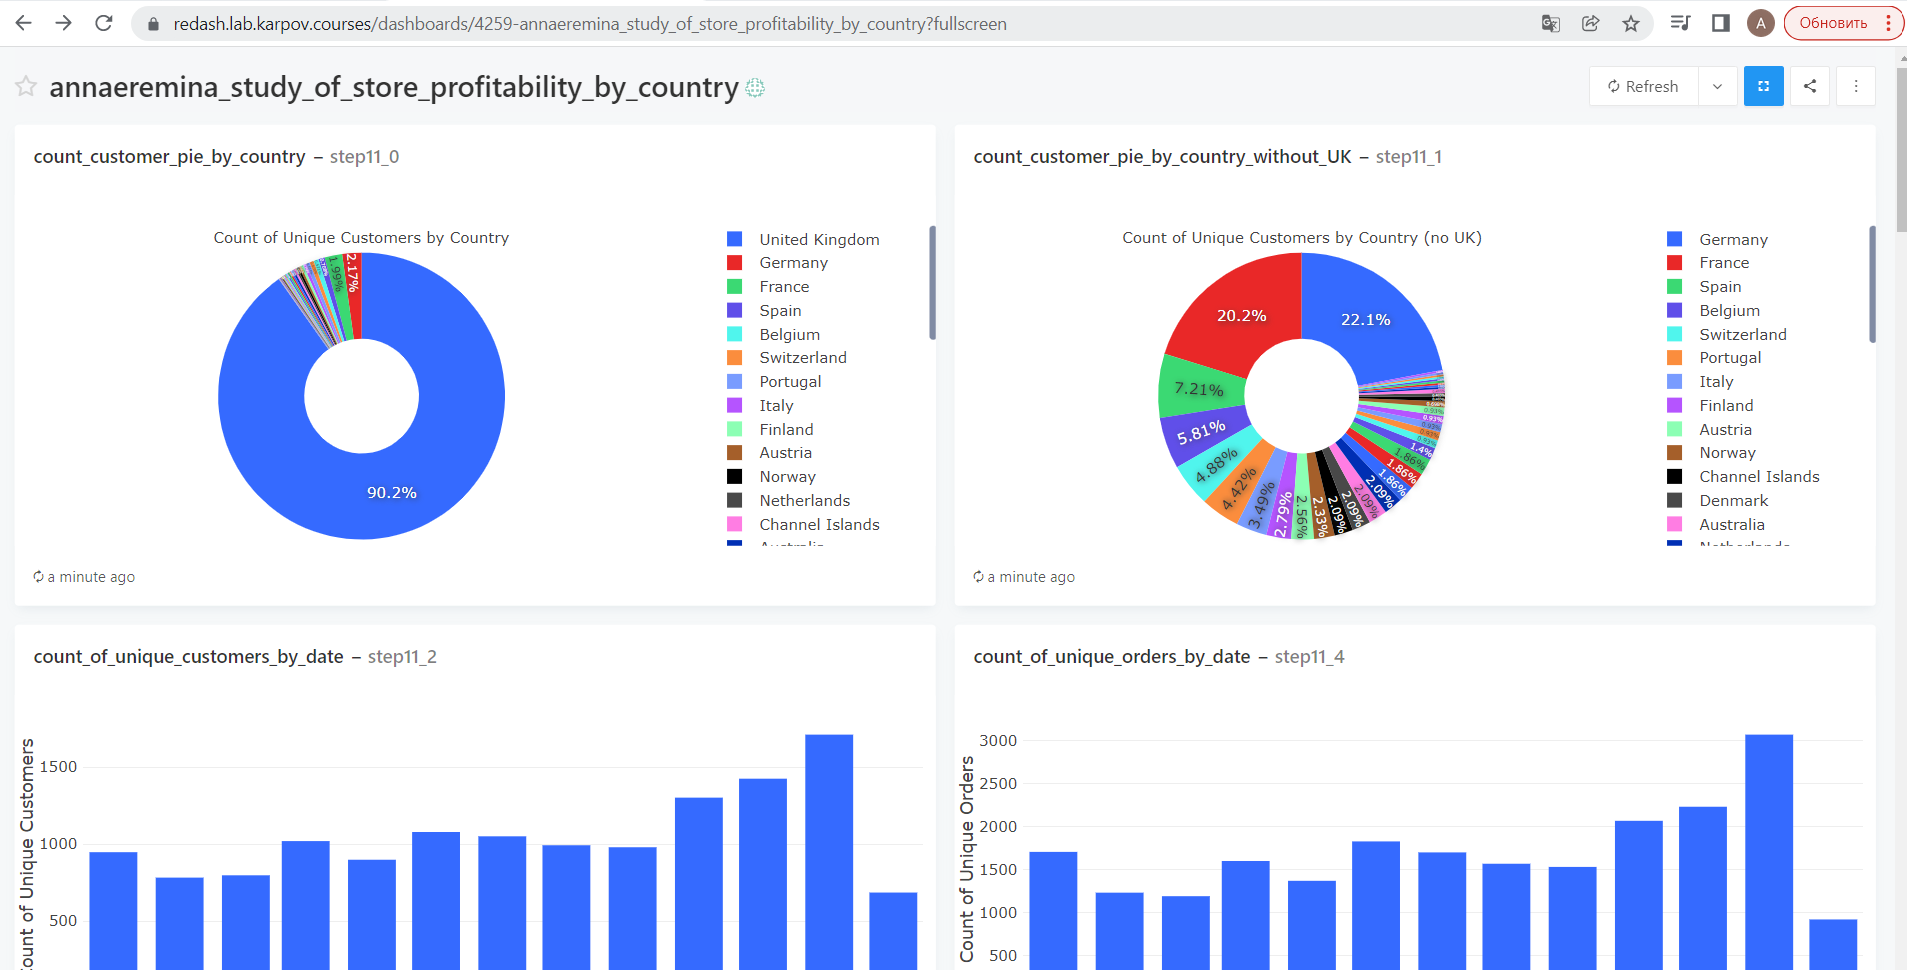

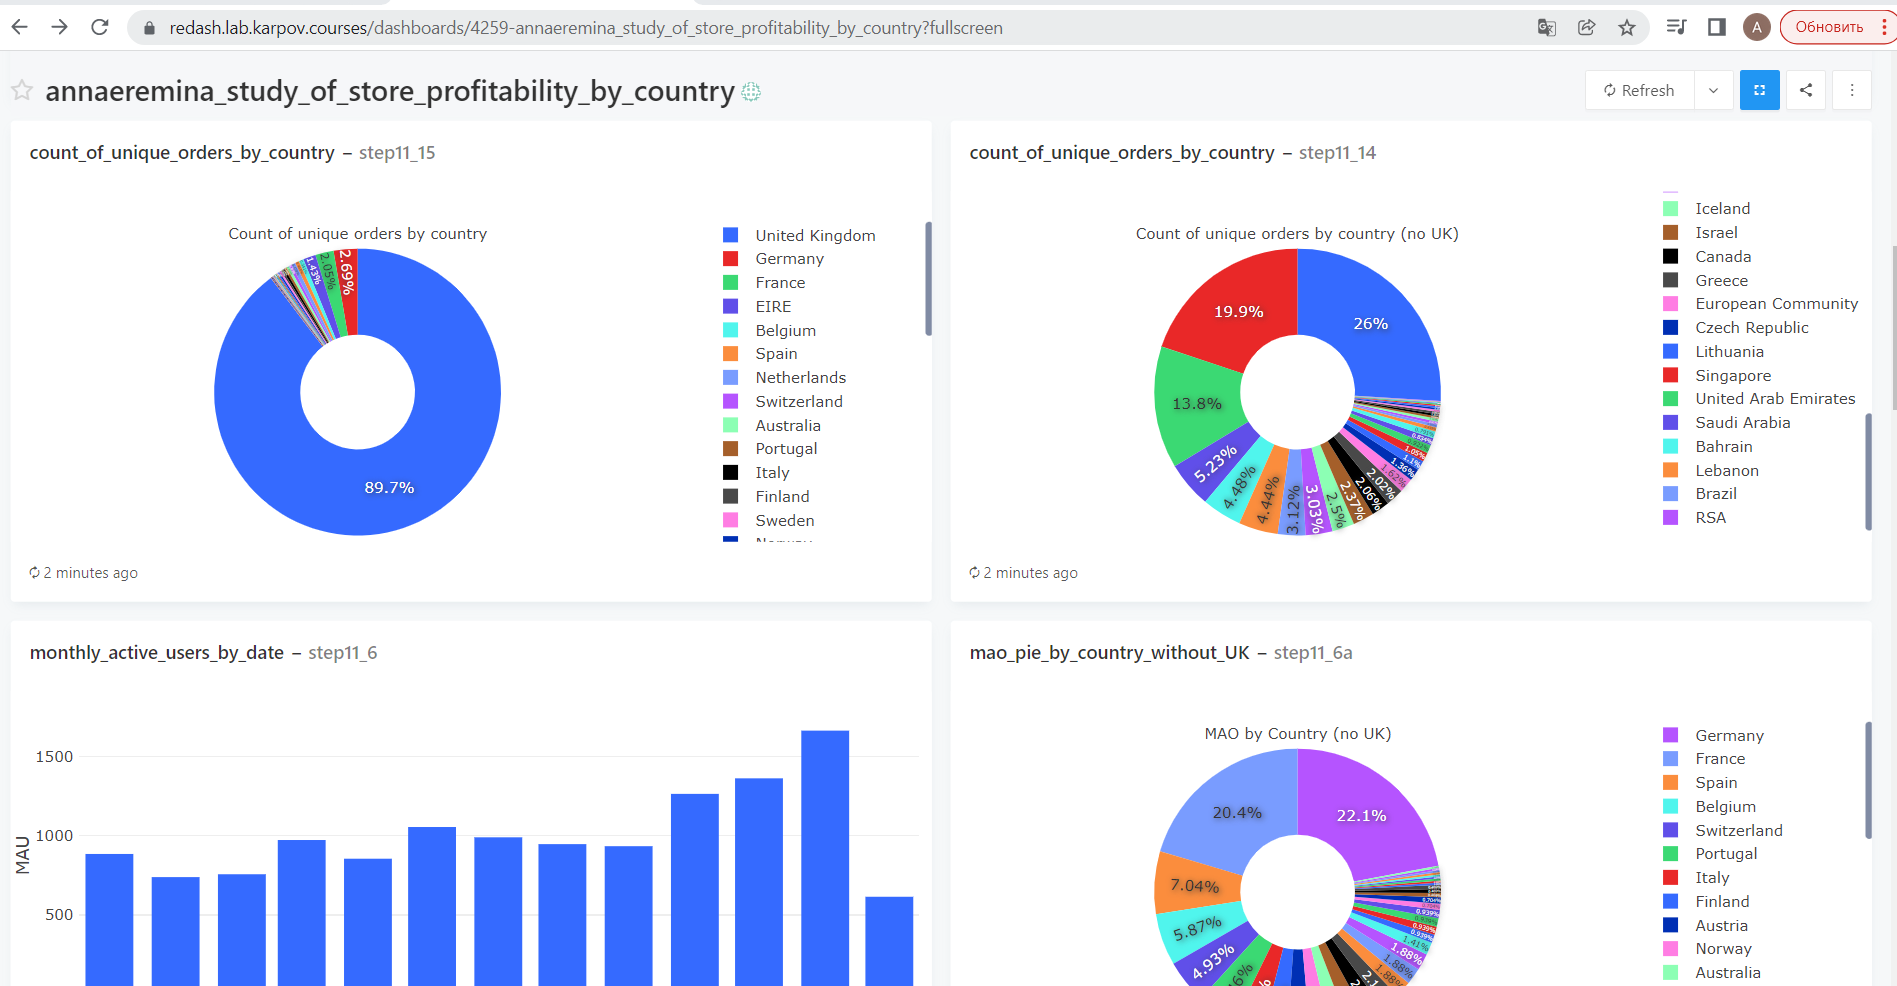

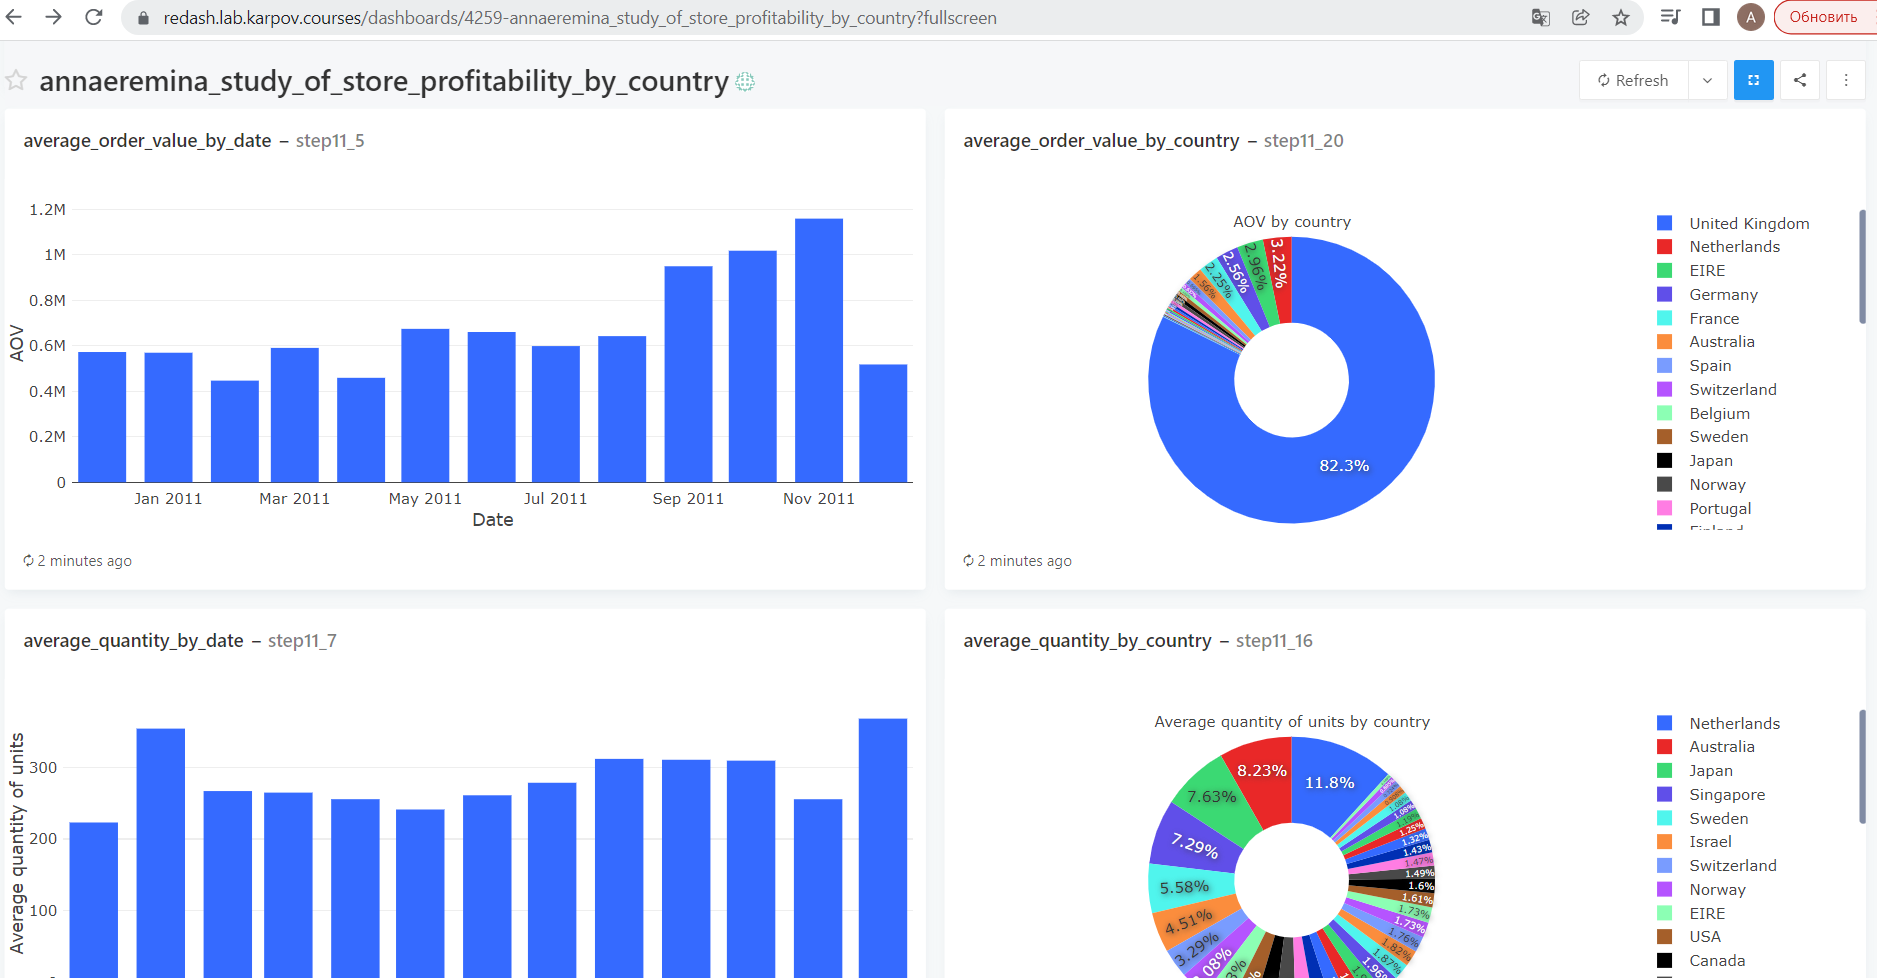

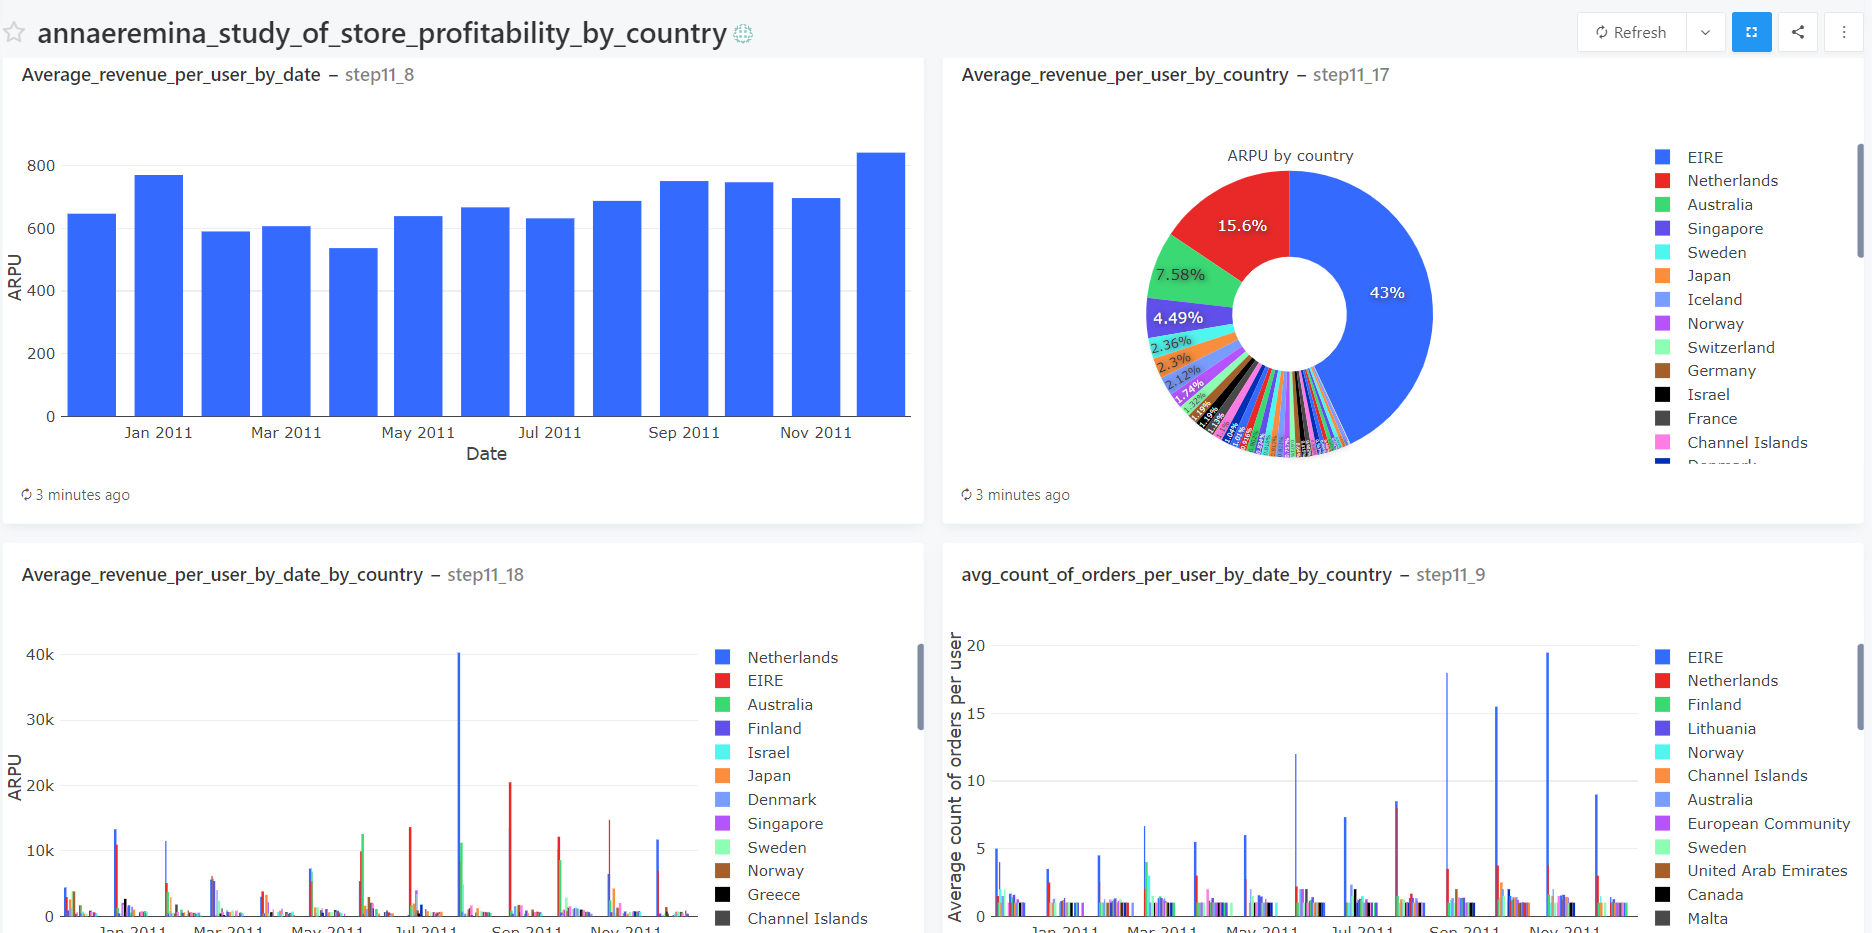

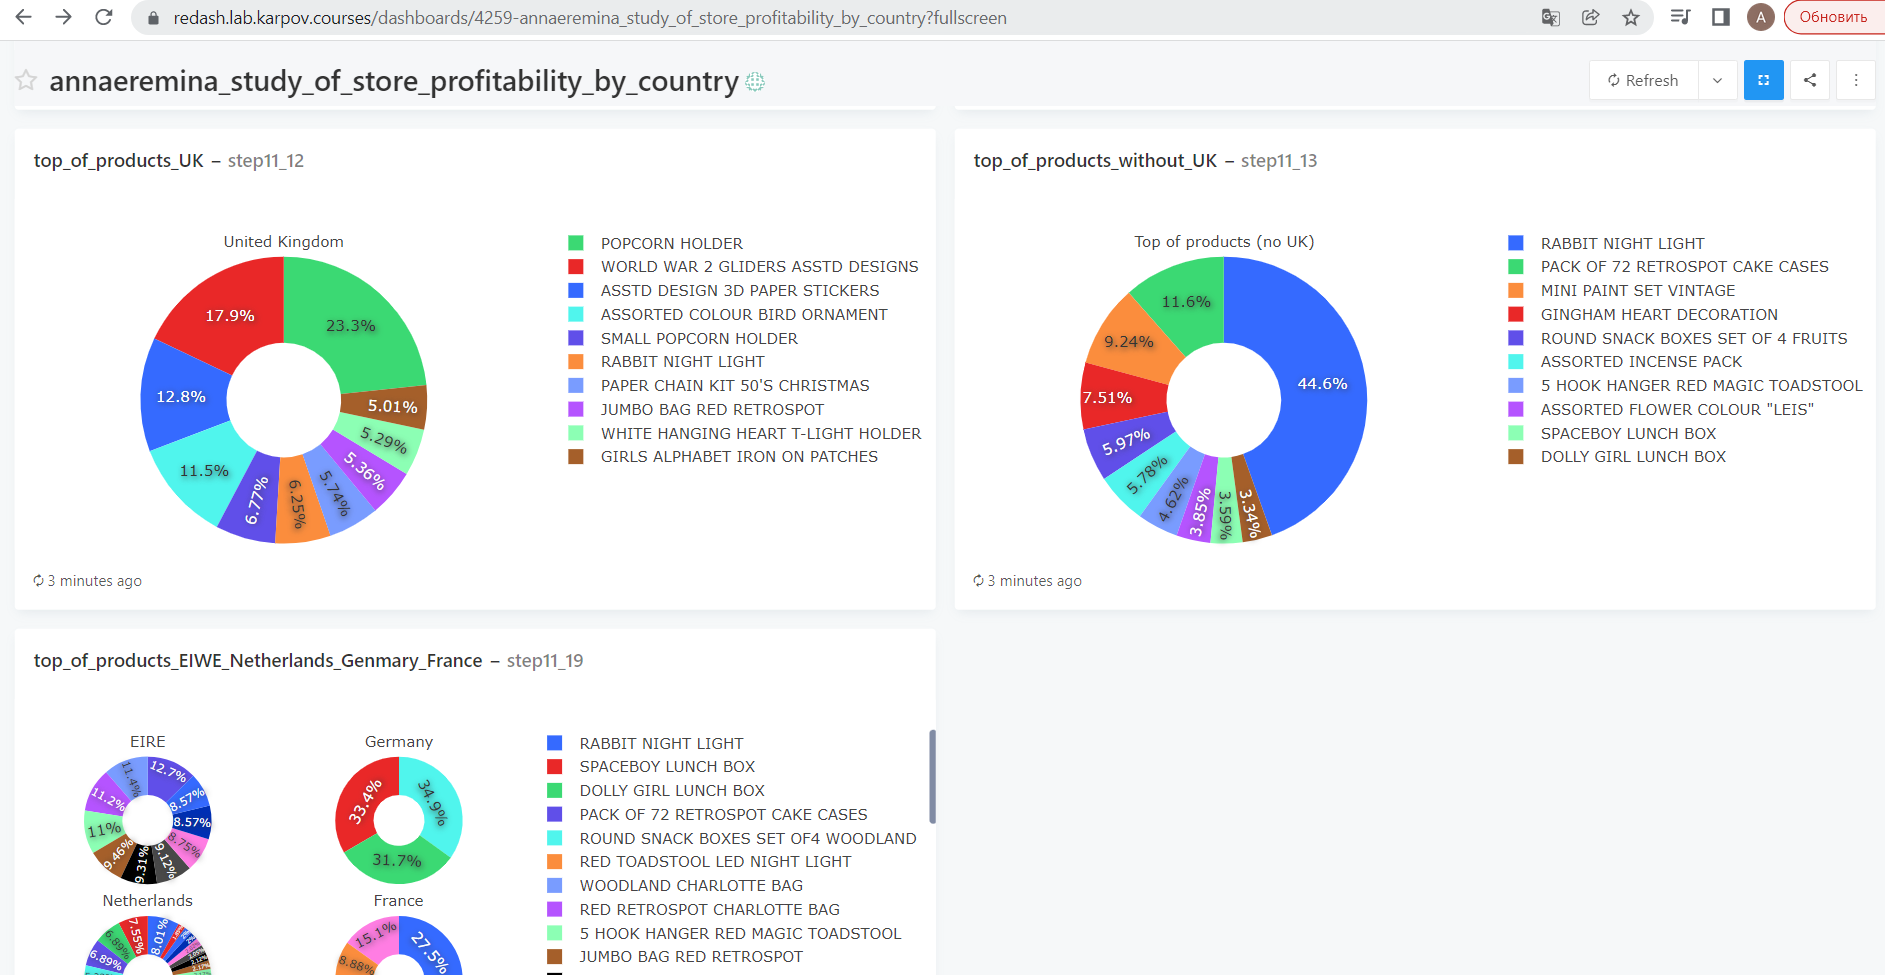

**Основные выводы по построенным графикам:**

1)	Диаграммы«Count of Unique Customers by Country». Лидирует Великобритания (90,2%), что неудивительно, так как магазин является британским. Можно сделать вывод, что компании следует продумать тактику привлечения клиентов из других стран, сделать интернет-рекламу. Если убрать из графика Великобританию, он становится более читаемым. Иностранные лидеры по числу пользователей: Германия (22,1%) и Франция (20,2%). 

2)	График «count_of_unique_customers_by_date». Имеем растущую линию тренда, что говорит о, хоть и медленном, но росте количества пользователей компании. Маленькое значение последнего столбца – из-за некорректной даты окончания сбора данных ранее окончания месяца (09.12.11).

3)	График «count_of_unique_orders_by_date» коррелирует с предыдущим графиком (№2) по уникальным пользователям, наблюдается рост числа заказов

4)	Диаграммы «Count of unique orders by country» (с Великобританией и без) в целом коррелируют с соответствующими графиками по числу уникальных пользователей (№1). Но в топ по числу заказов вошла Ирландия, можно сделать вывод, что там в среднем один пользователь делает большее число заказов, чем в других странах. Можно обратить внимание на эту страну, чтобы увеличить приток пользователей оттуда. 

5)	График «monthly_active_users_by_date» показывает положительную динамику числа активных пользователей (MAU), а также то, что в среднем около 95% пользователей являются активными, то есть совершают покупку в месяц, что является очень хорошим показателем.

6)	Активность пользователей также подтверждается в разбивке по странам на диаграмме «mao_pie_by_country_without_UK», имеет хорошее соответствие с диаграммой по пользователям (№1)

7)	Средняя выручка существенно повышается в течение года, согласно графику «average_order_value_by_date». За год AOV поднялось вдвое. 

8)	Согласно диаграмме «average_order_value_by_country» Нидерланды и Ирландия приносят больший процент дохода, чем «топовые» по пользователям Германия и Франция. 

9)	Среднее количество товаров (график «average_quantity_by_date) также возрастает, но менее выраженно. 

10)	В разбивке по странам (диаграмма average_quantity_by_country) по количеству товаров лидируют Нидерланды, Австралия и Япония. У Нидерландов это коррелирует с высокой средней выручкой. А у Австралии и Япония выручка ниже, соответственно так покупают дешевые товары, тогда как в лидирующих по другим показателям Великобритании, Германии и Франции берут не количеством товаров, а их высокой ценой и большим числом пользователей. 

11)	Динамика показателя ARPU (средняя выручка на одного активного пользователя) имеет  тенденцию роста (график «Average_revenue_per_user_by_date»), в течение года увеличился в 1,3 раза.

12)	Диаграмма «Average_revenue_per_user_by_country» - ARPU по странам. С большим перевесом лидируют Ирландия, затем Нидерланды и Сингапур. На графике «Average_revenue_per_user_by_date_by_country» с разбивкой по странам виден всплеск показателя по этим странам. Данные коррелируют с графиками №4 и №8 по числу заказов и AOV. Страны приносят хороший доход и нужно развивать продукцию в их направлении, увеличивая число пользователей.

13)	На графике «avg_count_of_orders_per_user_by_date_by_country» динамика среднего количества заказов на одного пользователя в разбивке по странам. Лидирует Ирландия. 

14)	Посмотрим на топ заказанных товаров по диаграммам «top_of_products». Так как превалирующее количество пользователей из Великобритании с наибольшим суммарным числом товаров, для них можно сделать отдельную диаграмму.

15)	И сделаем диаграмму по топовым товарам для наших топовых по MAU или по ARPU стран: «top_of_products_EIWE_Netherlands_Genmary_France», чтобы знать фаворитов пользователей. Эти страны лидируют по различным показателям из-за своей близости к Великобритании. Географическое положение сказывается также и на странах - «аутсайдерах» магазина


**Ревью:**
Общий балл: 8/10

\> Описана основная идея и выводы: 3.0 / 3

В целом всё хорошо: есть достаточно подробное описание проделанной работы и выводы по самим графикам! В качестве дополнительного улучшения:
- можно попробовать добавить фильтры, чтобы статистика показывалась за выбранный период или для конкретной категории, подробнее: [https://redash.io/help/user-guide/querying/query-parameters](https://redash.io/help/user-guide/querying/query-parameters "smartCard-inline")  и [https://redash.io/help/user-guide/dashboards/dashboard-editing#Dashboard-Filters](https://redash.io/help/user-guide/dashboards/dashboard-editing#Dashboard-Filters "smartCard-inline")
- попробовать другие виды графиков: например, KPI и текущие показатели можно показывать в виде big number (тип визуализации в редаше – counter ([https://redash.io/help/user-guide/visualizations/visualization-types](https://redash.io/help/user-guide/visualizations/visualization-types "smartCard-inline") )

\> Выбор графиков: 1.5 / 3

(1) Донат чарт не подходит для показа большого количества категорий, с ним стоит быть аккуратнее. В нескольких случаях одна категория также занимает почти всю площадь, из-за чего довольно сложно сделать содержательный вывод о ситуации с другими странами. Как вариант,
- можно показать значения в виде барчарта (или таблицы)
- сначала построить график UK/others (чтобы показать долю UK, здесь ок использовать донат), и добавить ещё один график с более детальной разбивкой (без UK, барчарт)

(2) Для показа динамики во времени лучше использовать line chart, а не bar, особенно если есть сравнение по нескольким категориям: столбики обычного барчарта смешиваются, из-за чего сложнее отследить динамику (т.е. line chart визуально легче воспринимается)

(3) Для топа товаров больше подойдет визуализация в виде таблицы. Получится более компактно, но при этом не менее информативно + можно вывести сразу несколько показателей (напр. название товаров, код, количество заказов, количество проданных единиц, выручку и т.п.)

\> Оформление и структура: 2.0 / 2

\> Общее впечатление: 1.5 / 2